<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/4%20Aprendizaje%20reforzado/Sesion%202/crossentropy_method_alm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crossentropy method

Vamos a aplicar el cross-entropy methos en el entorno Taxi-v2

In [1]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

Vamos a creae una politica que sea una distribución de probabilidad.

```policy[s,a] = P(take action a | in state s)```

Dado que aún utilizamos representaciones de acciones y estados enteros, puede utilizar una matriz bidimensional para representar la política.

Inicializar la política __uniformemente__, es decir, las probabilidades de todas las acciones deben ser iguales.


In [2]:
# INICIALIZA LA POLITICA
policy = np.ones((500,6))/6
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [5]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Interactuemos con el entorno

Al igual que antes, pero también registramos todos los estados y acciones que tomamos.

In [6]:
def generate_session(policy,t_max=10**4):
    """
    Juega el juego hasta el final o para t_max ticks.
    : política de param: una matriz de forma [n_estados, n_acciones] con probabilidades de acción
    : return: lista de estados, lista de acciones y suma de recompensas
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        # TOMA UNA ACCION DE MANERA ALEATORIA CON NP.RANDOM.CHOICE().
        a = np.random.choice(6, size=1, p=policy[s])[0]
        
        # Introducimos nuestra acción al entorno
        new_s, r, done, info = env.step(a)
        
        #Guarda state, action y añade reward a states,actions and total_reward correctamente. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        # Guarda el nuevo estado como el estado actual
        s = new_s
        if done:
            break
    return states, actions, total_reward
        

In [7]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]

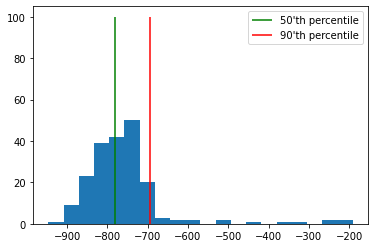

In [8]:
#Veamos los rewards iniciales

import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method pasos

In [11]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
 
    Selecciona estados y acciones  que tienen recompensas> = percentil
    : param states_batch: lista de estados, states_batch [session_i] [t]
    : param actions_batch: lista de listas de acciones, actions_batch [session_i] [t]
    : param rewards_batch: lista de recompensas, rewards_batch [session_i] [t]
    
    : devuelve: elite_states, elite_actions, listas 1D de estados y acciones respectivas de las sesiones de elite
    
    Por favor devuelva los estados y acciones de élite en su orden original.
    [es decir. ordenados por número de sesión y paso de tiempo dentro de la sesión]
    """
    #C ÁLCULA EL THRESHOLD SOBRE EL REWARD BATCH CON NP.PERCENTILE
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    # Calcula los estados elite y las acciones elite con un bucle compacto
    elite_states  = [state for i, session in enumerate(states_batch) for state in session if rewards_batch[i] >= reward_threshold]
    elite_actions = [action for i, session in enumerate(actions_batch) for action in session if rewards_batch[i] >= reward_threshold]
    
    return elite_states,elite_actions
    

In [12]:
#EJEMPLOS
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "MALr"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "MAL"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "MAL"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "MAL."
print("Ok!")

Ok!


In [13]:
test_result_40

([4, 2, 0, 2, 3, 1], [3, 2, 0, 1, 3, 3])

In [15]:
def update_policy(elite_states,elite_actions):
    """
    Dada la política anterior y una lista de estados / acciones de elite de select_elites,
    devuelve una nueva política actualizada donde cada probabilidad de acción es proporcional a
    
    política [s_i, a_i] ~ # [ocurrencias de si y ai en estados / acciones de élite]
    
    No olvide normalizar la política para obtener probabilidades válidas y manejar el caso 0/0.
    En caso de que nunca haya visitado un estado, establecer las probabilidades para todas las acciones en 1./n_actions
    
    : param elite_states: 1D lista de estados de sesiones de elite
    : param elite_actions: 1D lista de acciones de sesiones de elite
    """
    #DEFINE LA MATRIZ INICIALIZADA ALEATORIAMENTE PARA GUARDAR LA POLITICA NUEVA
    n_actions = 6
    new_policy = np.ones((500,6))/6
    
    for state in np.unique(elite_states):
        for action in range(n_actions):
            where_state = [elite_state for elite_state in elite_states if elite_state == state]
            where_action_in_state = [elite_state for i, elite_state in enumerate(elite_states) if elite_state == state and elite_actions[i] == action]
            new_policy[state, action] = len(where_action_in_state) / len(where_state)
            

    return new_policy

In [16]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "MAL"
assert np.all(new_policy>=0), "MAL"
assert np.allclose(new_policy.sum(axis=-1),1), "MAL"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


# ENTRENAMIENTO DE NUESTO MODELO
Generamos las sesiones y elegimos nuestos elite

In [18]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    CHARTS, CHARTS y CHARTS
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [19]:
#Reseteamos
policy = np.ones([n_states, n_actions]) / n_actions 

mean reward = -59.412, threshold=6.000


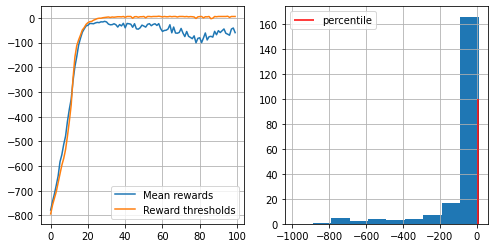

In [21]:
n_sessions = 250  #Sampleo
percentile = 50  # Percentil
learning_rate = 0.5  # alpha

log = []

for i in range(100):
    
    # GENERA UNA LISTA CON NUMEOR DE SESIONES Y NUEVAS SESIONES
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)
    #EXTRAE LOS ESTADOS ELITE DEL PROCESO CON SELECT ELITES
    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile=percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    # DA ESTABILIDAD A LA NUEVA POLITICA CON UN LEARNING RATE (ACTUALIZACION POLITICA CON LA FORMULA)
    policy = learning_rate * policy + (1-learning_rate) * new_policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)